### 2nd European Conference on Social Networks, June 14-17, 2016, Paris (http://eusn2016.sciencesconf.org/)
## Workshop 12:
# EXTRACTING SOCIAL NETWORKS FROM LITERARY TEXT
# II. Using Names of Characters from Inside the Text
## By Moses Boudourides (<mailto:Moses.Boudourides@gmail.com>) and Sergios Lenis (<mailto:sergioslenis@gmail.com>) 
## University of Patras, Greece

**IMPORTANT**: To use this notebook, you'll need to

1. Install IPython Notebook (easiest way: use [Anaconda](http://store.continuum.io))
2. Download this notebook and all other Python scripts used here from [https://github.com/mboudour/WordNets/blob/master/EUSN2016_LiteraryTextNetworksWorkshop](https://github.com/mboudour/WordNets/blob/master/EUSN2016_LiteraryTextNetworksWorkshop)
3. Run `ipython notebook` in the same directory where notebook and scripts were put

<a href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

<p>
**Table of Contents**

[I. Importing the Text & Names of Characters](#I)

[II. Descriptive Statistics of Characters](#II)

[III. The Two-Mode Network of Characters and Sentences](#III)

[IV. The Network of Sententially Co-Occurring Characters](#IV)

[V. Trajectories of Transitions among Sentential Co-Occurrences of Characters](#V)

## Importing Python modules 

In [1]:
import random
import nltk
import codecs
# from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os
import imp
import seaborn as sns       # pip install seaborn
sns.set_style("white")      # For seaborn to show axes in iPython Notebook
from lightning import Lightning
from numpy import random, asarray, sqrt, arctan2, pi, clip
from seaborn import color_palette
from sklearn import datasets
from colorsys import hsv_to_rgb

# utilsdir='/Users/mosesboudourides/Dropbox/Python Projects/EUSN2016_LiteraryTextNetworksWorkshop/utils/'
# utilsdir='/home/mab/Dropbox/Python Projects/utils/'#tools.py'
utilsdir='/home/mab/Dropbox/Python Projects/EUSN2016_LiteraryTextNetworksWorkshop/utils/'

%matplotlib inline 
%load_ext autoreload

/home/mab/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# The case of William Shakespeare's "Hamlet"

<a id='I'></a>
## I. Importing the Text & Names of Characters

In [2]:
# The transcript of William Shakespeare's Hamlet was downloaded from 
# http://shakespeare.mit.edu/hamlet/full.html (accessed on 4-18-2016)

filename = 'texts/Hamlet: Entire Play.txt'
titlename = "William Shakespeare's Hamlet"
central_hero = 'Hamlet'
nn1 = "William Shakespeare's Hamlet selected terms"
nn2 = "William Shakespeare's Hamlet Characters"
vname1 = 'vids/Hamlet.gif'
vname2 = 'vids/Hamlet.mp4'
nn3 = "['Hamlet']"
filename1 = 'S_out_graphs/Hamlet_graph.graphml'

f=open(filename)

num_lines = 0
num_words = 0
num_chars = 0
names=set()
for line in f:    
    words = line.split()
    num_lines += 1
    num_words += len(words)
    num_chars += len(line)
    lin=line.strip()
    if len(lin)>0:
        if lin[0]=='*' and lin[-1]=='*':
            lin=lin[1:-1]
            if '*' in lin:                
                nlin=lin.split()
                for nl in nlin:
                    nl=nl.strip('*')
                    names.add(nl.strip(':'))
            else:
                names.add(lin)
print "%s has number of words = %i and number of characters = %i" %(titlename,num_words,num_chars)

f = codecs.open(filename, "r", encoding="utf-8").read()

William Shakespeare's Hamlet has number of words = 32015 and number of characters = 197464


In [3]:
# "names" are defined as the the words in lines of the text including a single word.

list(names)

['GUILDENSTERN',
 'First Priest',
 'Gentleman',
 'LUCIANUS',
 'OSRIC',
 'Lord',
 'PRINCE FORTINBRAS',
 'First Ambassador',
 'MARCELLUS',
 'ROSENCRANTZ',
 'Captain',
 'Player King',
 'Ghost',
 'First Sailor',
 'HORATIO',
 'BERNARDO',
 'Servant',
 'LAERTES',
 'HAMLET',
 'Second Clown',
 'Prologue',
 'First Player',
 'First Clown',
 'All',
 'FRANCISCO',
 'LORD POLONIUS',
 'OPHELIA',
 'Danes',
 'REYNALDO',
 'VOLTIMAND',
 'KING CLAUDIUS',
 'Player Queen',
 'QUEEN GERTRUDE',
 'Messenger',
 'CORNELIUS']

In [4]:
dici={'GUILDENSTERN':'GUILDENSTERN',
 'First Priest':'Priest',
      'Priest':'Priest',
 'LUCIANUS':'Players',
      'Players':'Players',
 'OSRIC':'Osric',
 'PRINCE FORTINBRAS':'FORTINBRAS',
      'FORTINBRAS':'FORTINBRAS',
 'First Ambassador':'Ambassadors',
      'Ambassadors':'Ambassadors',
 'MARCELLUS':'Marcelius',
 'ROSENCRANTZ':'ROSENCRANTZ',
 'Captain':'Captain',
 'Player King':'Players',
 'Ghost':'Ghost',
 'First Sailor':'Sailors',
      'Sailor':'Sailors',
 'HORATIO':'Horatio',
 'BERNARDO':'Bernardo',
 'Servant':'Servant',
 'LAERTES':'Laertes',
 'HAMLET':'Hamlet',
      'Lord Hamlet':'Hamlet',
 'Second Clown':'Clowns',
 'First Player':'Players',
 'First Clown':'Clowns',
 'FRANCISCO':'Francisco',
 'LORD POLONIUS':'Polonius',
 'OPHELIA':'Ophelia',
 'Danes':'Danes',
 'REYNALDO':'Reynaldo',
 'VOLTIMAND':'VOLTIMAND',
 'KING CLAUDIUS':'Claudius',
      'Claudius':'Claudius',
 'Player Queen':'Players',
 'QUEEN GERTRUDE':'Gertrude',
      'Gertrude':'Gertrude',
 'Messenger':'Messenger',
 'CORNELIUS':'Cornelius'}

ndici={i.lower():k.lower().capitalize() for i,k in dici.items()}
dnici=[(i.split()[0],i.split()[1]) for i in ndici.keys() if len(i.split())>1]

selectedTerms=ndici.keys()
new_text={l:{} for l in selectedTerms}
f=open(filename)
chars=[]
texx=''
u=0
for lin in f:
    lin=lin.strip()
    if '*' in lin:
        if len(chars)>0 and len(texx)>0:
            for cr in chars:
                new_text[cr[0]][cr[1]]=texx
        chars=[]
        line= lin.split('*')
        
        for ll in line:
            if ll.lower() in selectedTerms:
                chars.append((ll.lower(),u))
        texx=''
    elif len(lin)>0 and lin[0] =='/':
        continue
    else:
        if len(chars)>0:
            texx+=lin
    u+=1     

In [5]:
%autoreload 2

tool= imp.load_source('tools', utilsdir+'tools.py')
# print dir(tool)

create_pandas_dataframe_from_text_par=tool.create_pandas_dataframe_from_text_par
create_coo_graph=tool.create_coo_graph

dfst,sec_prot,coccurlist,occurlist,dflines=create_pandas_dataframe_from_text_par(new_text,selectedTerms,ndici,titlename)
co_graph=create_coo_graph(coccurlist)

dfst.rename(columns={nn1:nn2},inplace=True)
# dfst.rename(columns={"Arthur Conan Doyle's A Study in Scarlet selected terms":"Arthur Conan Doyle's A Study in Scarlet Characters"},inplace=True)
dfst.sort_values(by='Frequencies').sort(["Frequencies"], ascending=[0])

/home/mab/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,William Shakespeare's Hamlet Characters,Frequencies
23,Hamlet,424.0
10,Horatio,139.0
13,Claudius,104.0
8,Polonius,86.0
1,Laertes,84.0
0,Gertrude,79.0
6,Ophelia,78.0
21,Rosencrantz,56.0
17,Clowns,45.0
19,Guildenstern,44.0


In [6]:
prot_pol_sub=dflines[['narrator','protagonists','#_of_protagonists','polarity','subjectivity']].reset_index()
prot_pol_sub['sentence_id']=prot_pol_sub.index
prot_pol_sub=prot_pol_sub[['sentence_id','narrator','protagonists','#_of_protagonists','polarity','subjectivity']]

cuts = 0
# prot_pol_sub = prot_pol_sub[prot_pol_sub['#_of_protagonists']>cuts]
lp = prot_pol_sub['protagonists'].tolist()
lpn = []
for i in lp:
    for j in i:
        lpn.append(j)
# len(set(lpn))
print "The total number of sentences in %s is %i." %(titlename,len(prot_pol_sub))
# print "The total number of sentences in %s with at least %i characters in each one of them is %i." %(titlename,cuts+1,len(prot_pol_sub))
prot_pol_sub.rename(columns={'protagonists':'Lists_of_Characters','#_of_protagonists':'#_of_Characters','polarity':'Polarity','subjectivity':'Subjectivity'},inplace=True)
prot_pol_sub.sort(["#_of_Characters"], ascending=[0]) 
ddff = prot_pol_sub.drop('sentence_id', 1)
ddff.index.name = 'Sentence_ID'
ddff.head(10)

/home/mab/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The total number of sentences in William Shakespeare's Hamlet is 1136.


,narrator,Lists_of_Characters,#_of_Characters,Polarity,Subjectivity
Sentence_ID,,,,,
0,Sailors,[],0.0,0.000000,0.000000
1,Sailors,[Horatio],1.0,0.000000,0.000000
2,Laertes,[Ophelia],1.0,0.000000,0.000000
3,Laertes,[],0.0,0.000000,0.000000
4,Laertes,[],0.0,0.166667,0.333333
5,Laertes,[],0.0,0.000000,0.000000
6,Laertes,[],0.0,-0.200000,0.500000
7,Laertes,[],0.0,0.000000,0.000000
8,Laertes,[],0.0,-0.125000,0.700000


<a id='II'></a>
## II. Descriptive Statistics of Characters

In [7]:
prot_pol_sub[['#_of_Characters','Polarity','Subjectivity']].describe()

,#_of_Characters,Polarity,Subjectivity
count,1136.000000,1136.000000,1136.000000
mean,0.171655,0.095115,0.271018
std,0.472623,0.260839,0.317240
min,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.175830,0.535714
max,4.000000,1.000000,1.000000


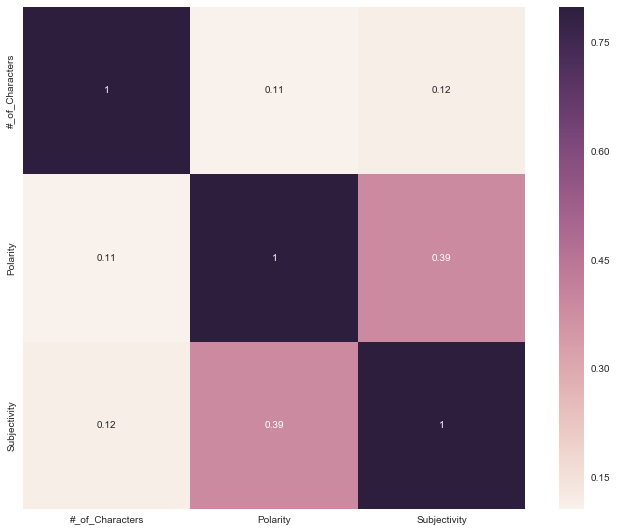

In [8]:
ddff = prot_pol_sub.drop('sentence_id', 1)
corrmat = ddff.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

/home/mab/.local/lib/python2.7/site-packages/pandas/tools/plotting.py:3369: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "the passed axes is being cleared", UserWarning)


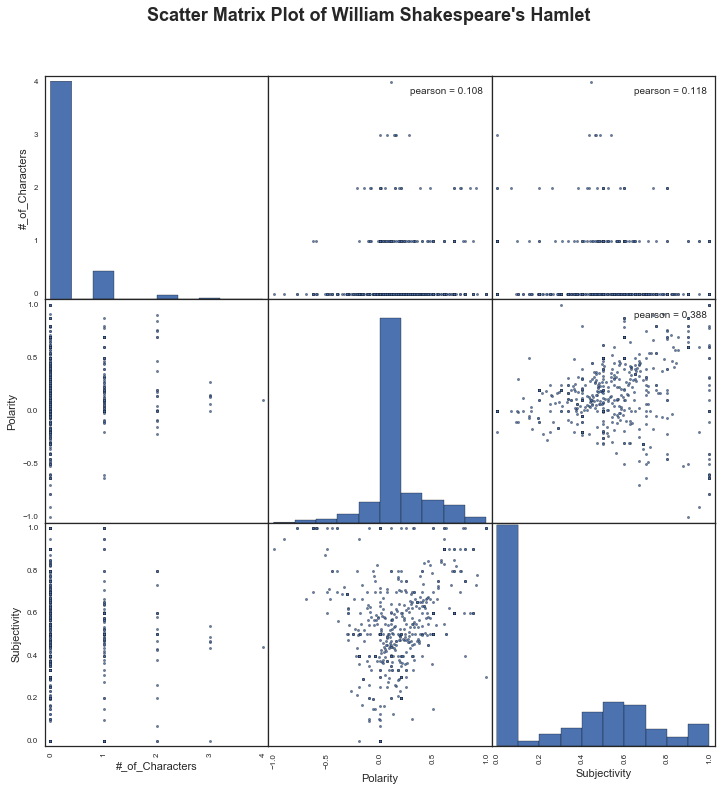

In [9]:
from pandas.tools.plotting import scatter_matrix

ntei='Scatter Matrix Plot of ' + titlename
f, ax = plt.subplots(figsize=(12,12))
# nddd
sss=scatter_matrix(ddff[['#_of_Characters','Polarity','Subjectivity']], alpha=0.9, color='black', diagonal='hist',ax=ax)
plt.suptitle(ntei,fontsize=18,fontweight='bold')
corr = ddff.corr().as_matrix() #nddd.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sss, k=1)):
    sss[i, j].annotate("pearson = %.3f" %corr[i,j], (0.8, 0.93), xycoords='axes fraction', ha='center', va='center')

### The Histogram of the Number of Characters 

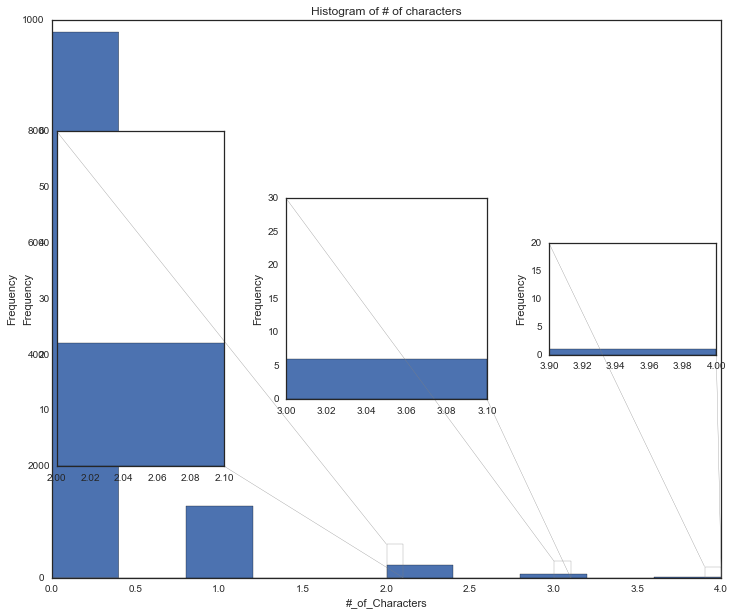

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

ndfl=dflines[dflines['#_of_protagonists']>0  ]

fig, ax = plt.subplots(figsize=[12, 10])
axes2 = zoomed_inset_axes(ax, 12, loc=10)  # zoom = 6

dflines['#_of_protagonists'].plot.hist(ax=ax)

ax.set_xlabel('#_of_Characters')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of # of characters')

x1, x2, y1, y2 = 3, 3.1, 0, 30
axes2.set_xlim(x1, x2)
axes2.set_ylim(y1, y2)
ndfl['#_of_protagonists'].plot.hist(ax=axes2)
axes2.set_ylabel('Frequency')

mark_inset(ax, axes2, loc1=2, loc2=4, fc="none", ec="0.5")
axes3 = zoomed_inset_axes(ax, 10, loc=6)

x1, x2, y1, y2 = 2, 2.1, 0, 60
axes3.set_xlim(x1, x2)
axes3.set_ylim(y1, y2)
ndfl['#_of_protagonists'].plot.hist(ax=axes3)
axes3.set_ylabel('Frequency')

mark_inset(ax, axes3, loc1=2, loc2=4, fc="none", ec="0.5")

axes4 = zoomed_inset_axes(ax, 10, loc=7)

x1, x2, y1, y2 = 3.9, 4, 0, 20
axes4.set_xlim(x1, x2)
axes4.set_ylim(y1, y2)
ndfl['#_of_protagonists'].plot.hist(ax=axes4)
axes3.set_ylabel('Frequency')

mark_inset(ax, axes4, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

### Various Scatter Plots

In [11]:
x = ddff['Polarity']
y = ddff['Subjectivity']
z = ddff['#_of_Characters']


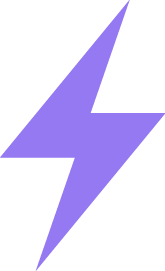

Connected to server at http://public.lightning-viz.org


<IPython.core.display.Javascript object>

In [12]:
lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')

In [13]:
series = [x,y]
lgn.line(series)

/home/mab/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [14]:
viz = lgn.scatter(x, y, values = z, alpha=0.6, colormap='YlOrRd')
viz

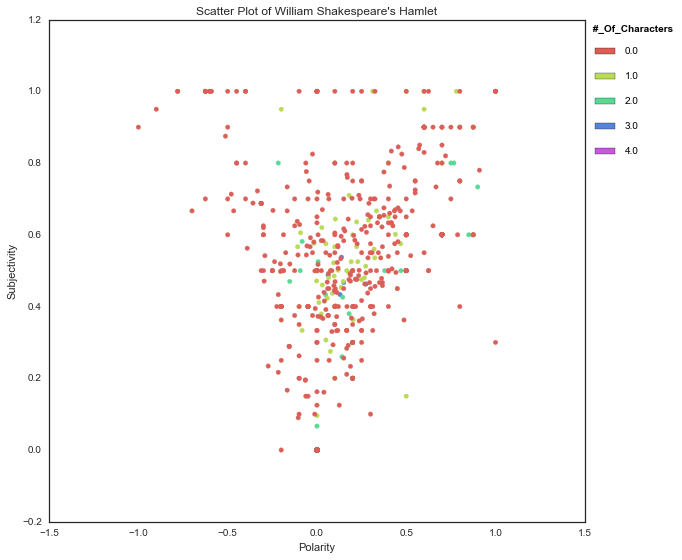

<ggplot: (8753933920153)>

In [15]:
from ggplot import *
import matplotlib as mpl

ntei='Scatter Plot of ' + titlename

p = ggplot(aes(x='Polarity', y='Subjectivity',color='#_of_Characters'), data=ddff) #nddd)
p + geom_point() + ggtitle(ntei) + theme_matplotlib(rc={"figure.figsize": "12, 9"}, matplotlib_defaults=False)

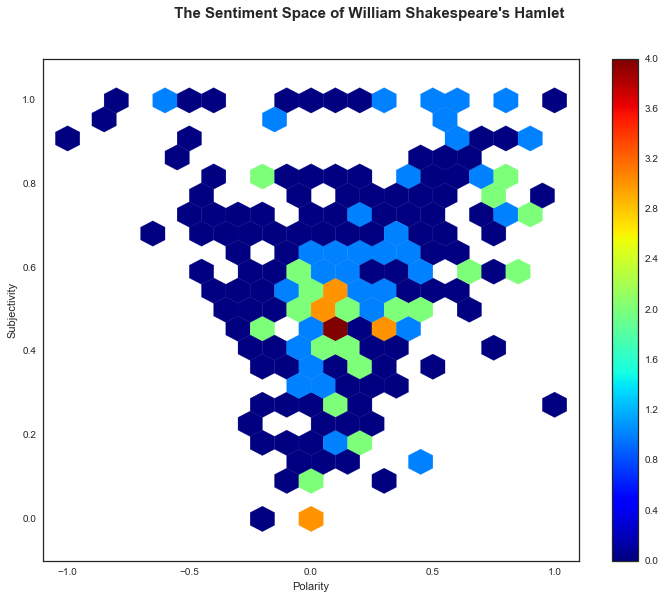

In [16]:
ntei=' The Sentiment Space of ' + titlename
f, ax = plt.subplots(figsize=(12,9))
ddff.plot.hexbin(x='Polarity',y='Subjectivity',gridsize=20,C='#_of_Characters',ax=ax,reduce_C_function=max,cmap='jet')#,title=ntei)
plt.xlim(-1.1, 1.1)
plt.ylim(-.1, 1.1)
plt.suptitle(ntei,fontsize=15,fontweight='bold')

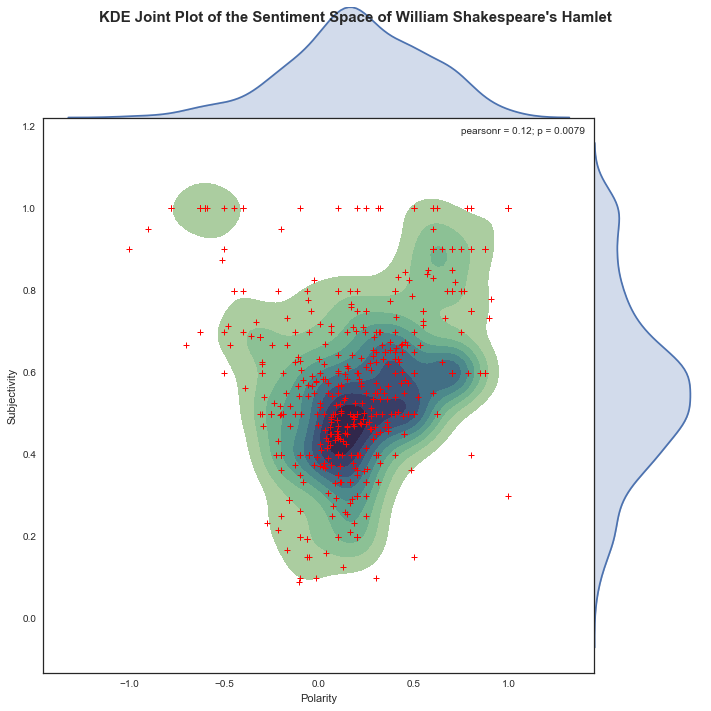

In [17]:
nddd=ddff[ddff['Polarity'] !=0 ]#& ddff['Subjectivity'] !=0]
nddd=nddd[nddd['Subjectivity'] !=0]

ntei='KDE Joint Plot of the Sentiment Space of ' + titlename
# f, ax = plt.subplots(figsize=(10,10))
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
ggn=sns.jointplot(x='Polarity',y='Subjectivity', data=nddd, kind ="kde",cmap=cmap,space=0, size=10) #, ax=ax) #kind="kde",
# sns.kdeplot(nddd['Polarity'],nddd['Subjectivity'], cmap=cmap, shade=True)
ggn.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
ggn.ax_joint.collections[0].set_alpha(0)
ggn.set_axis_labels("Polarity", "Subjectivity")
plt.suptitle(ntei,fontsize=15,fontweight='bold')

In [18]:
# pols=nddd.Polarity.tolist()
# subj=nddd.Subjectivity.tolist()
# ntei=titlename+' in Sentiment Space'
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# plt.xlim(-1.1, 1.1)
# plt.ylim(-.1, 1.1)
# ax.set_xlabel('Polarity')
# ax.set_ylabel('Subjectivity')   

# # arro=ax.arrow(pols[0], subj[0], pols[1]-pols[0], subj[1]-subj[0], head_width=0.03, head_length=0, fc='b', ec='b',
# #                   length_includes_head=False,
# # # #                  head_starts_at_zero=True
# # # #                  overhang=-.51
# #                  fill=False)

# def animate(i):
#     col=(1.*i/(1.*len(pols)),.5,.5)
#     plt.plot(pols[i],subj[i],'o',color=col, markersize=5)
# #     return arro,

# ani = animation.FuncAnimation(fig, animate, np.arange(0, len(pols)-1), 
#     interval=25, blit=False)

# # ani.save(vname2)#, metadata={'artist':'Guido'})
# ani.save(vname1, writer='imagemagick')
# plt.show()
# print len(pols)

In [19]:
# %%bash
# ffmpeg -f gif -i vids/Hamlet.gif vids/Hamlet.mp4

In [20]:
import io
import base64
from IPython.display import HTML

video = io.open(vname2, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# /Users/mosesboudourides/Dropbox/Python Projects/LiteratureNetworks/ArthurConanDoyle/SherlockHolmesStoriesNetwork/

<a id='III'></a>
## III. The Two-Mode Network of Characters and Sentences 

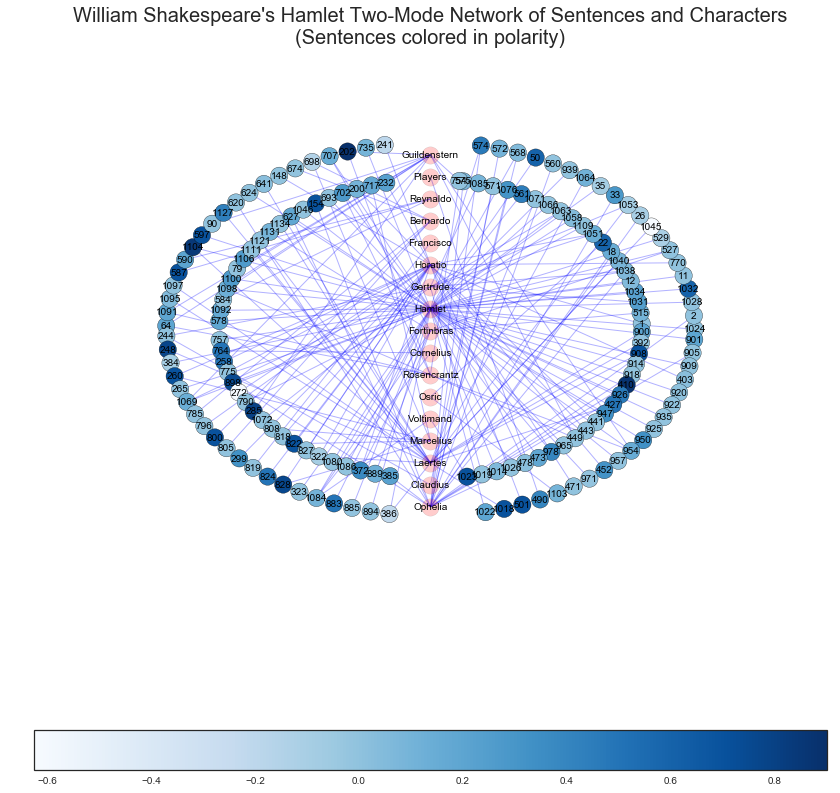

In [21]:
%autoreload 2
import math

draw_network_node_color=tool.draw_network_node_color

sstt="%s Two-Mode Network of Sentences and Characters" %titlename
pos=nx.spring_layout(sec_prot)
nds=[nd for nd in sec_prot.nodes() if isinstance(nd,int)]
prot=[nd for nd in sec_prot.nodes() if nd not in nds]
qua=len(nds)/4.
for en,nd in enumerate(nds):  
    if en<qua:
        if en%2==0:
            rr=1.
        else:
            rr=.8
        the=math.pi*en/(190*72./len(nds))
        pos[nd][0]=rr*math.cos(the)
        pos[nd][1]=rr*math.sin(the)
    elif en<len(nds)/2. and en>qua:
        ens=en-qua
        the=math.pi*ens/(190*72./len(nds))
        if en%2==0:
            rr=1.
        else:
            rr=.8
        pos[nd][0]=-rr*math.cos(the)
        pos[nd][1]=rr*math.sin(the)
    elif en<3*qua and en>2*qua:
        ens=en-2*qua
        the=math.pi*ens/(190*72./len(nds))
        if en%2==0:
            rr=1.
        else:
            rr=.8
        pos[nd][0]=-rr*math.cos(the)
        pos[nd][1]=-rr*math.sin(the)
    else:
        ens=en-3*qua
        the=math.pi*ens/(190*72./len(nds))
        if en%2==0:
            rr=1.
        else:
            rr=.8
        pos[nd][0]=rr*math.cos(the)
        pos[nd][1]=-rr*math.sin(the)
for en ,nd in enumerate(prot):
    pos[nd][0]=0
    pos[nd][1]=-0.95+en*2./len(prot)

possit=draw_network_node_color(sec_prot,sstt,pos=pos,with_edgewidth=False,withLabels=True,labfs=10,valpha=0.2,
                               ealpha=0.3,labelfont=5,with_node_weight=False,node_size_fixer=10.,node_col='polarity',
                              node_size_def=None)

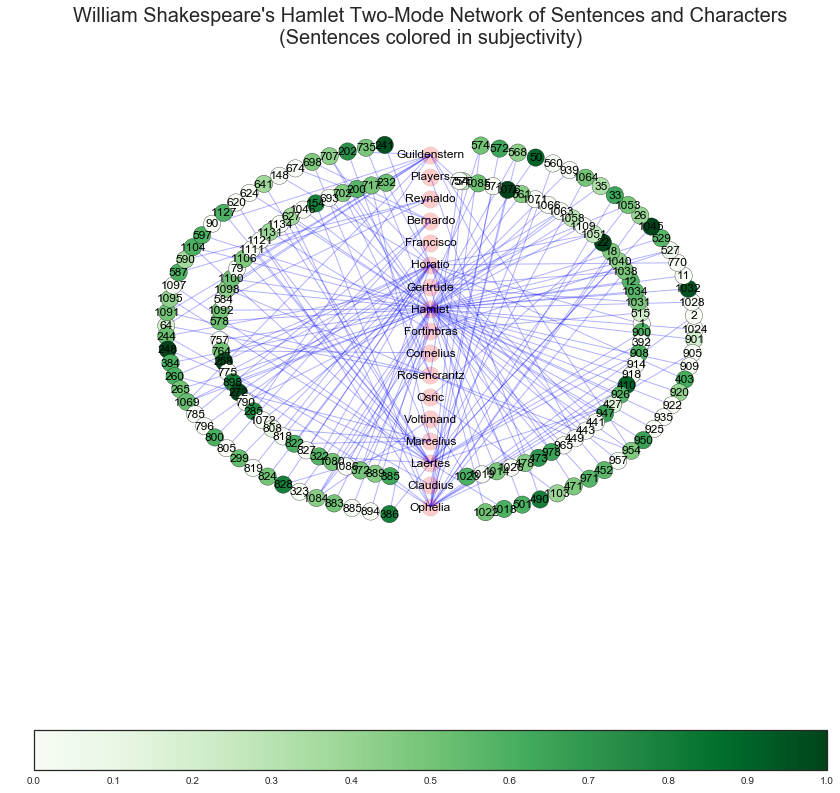

In [22]:
possit=draw_network_node_color(sec_prot,sstt,pos=pos,with_edgewidth=False,withLabels=True,labfs=12,valpha=0.2,
                               ealpha=0.3,labelfont=15,with_node_weight=False,node_size_fixer=300.,
                               node_col='subjectivity',colormat='Greens')

<a id='IV'></a>
## IV. The Network of Sententially Co-Occurring Characters 

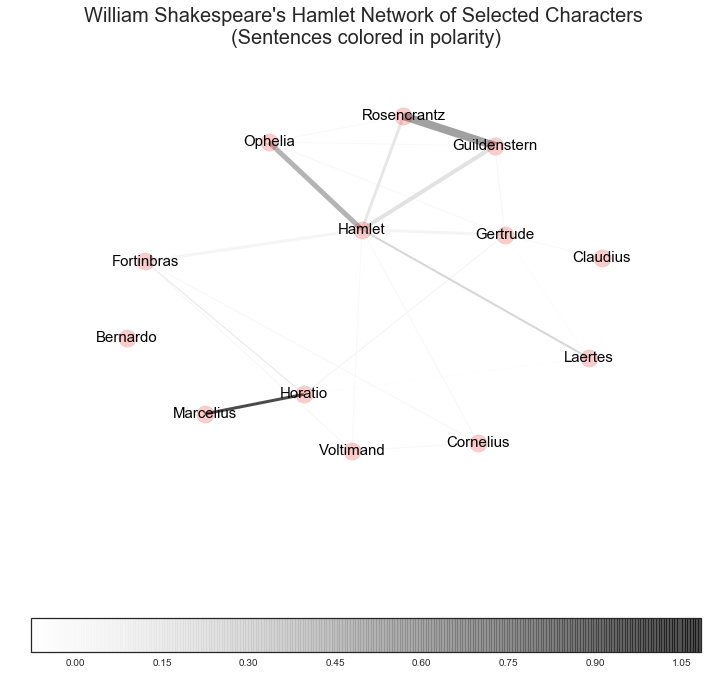

In [23]:
%autoreload 2

draw_network=tool.draw_network
make_graph_from_lists=tool.make_graph_from_lists


plist = prot_pol_sub['Lists_of_Characters'].tolist()
pplist=prot_pol_sub['Polarity'].tolist()
nplist=prot_pol_sub['#_of_Characters'].tolist()
splist=prot_pol_sub['Subjectivity'].tolist()

G = make_graph_from_lists(plist,pplist,nplist,splist)
posg=nx.spring_layout(G,scale=50,k=0.55,iterations=20)
# posg=nx.spring_layout(G,scale=50)#,k=0.55)#,iterations=20)

sstt="%s Network of Selected Characters \n(Sentences colored in polarity)" %titlename
possit=draw_network(G,sstt,pos=posg,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.7,labelfont=15,
                   with_edgecolor=True,edgecolor='polarity',colormat='Blues')

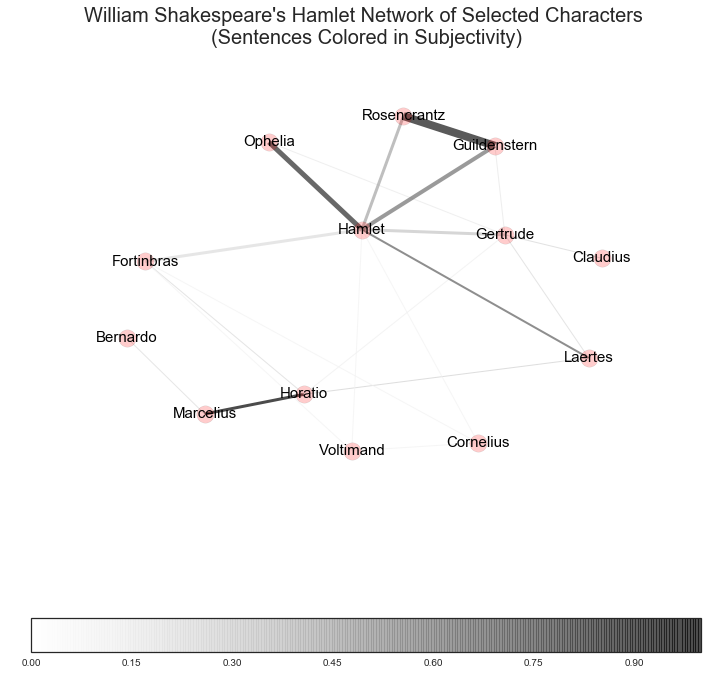

In [24]:
sstt="%s Network of Selected Characters \n(Sentences Colored in Subjectivity)" %titlename
possit=draw_network(G,sstt,pos=posg,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.7,labelfont=15,
                   with_edgecolor=True,edgecolor='subjectivity',colormat='Greys')

### Centralities of Nodes in the Network of Sententially Co-Occurring Characters

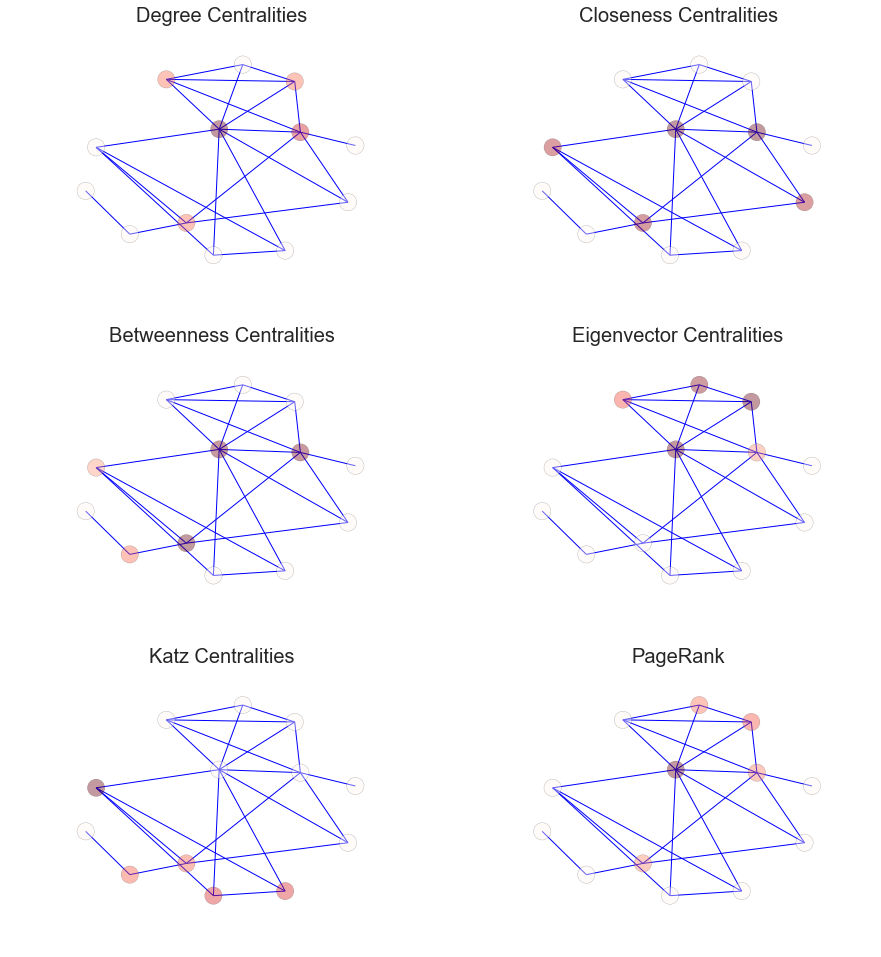

In [25]:
draw_centralities_subplots=tool.draw_centralities_subplots

centrali=draw_centralities_subplots(G,pos=posg,withLabels=False,labfs=5,figsi=(15,22),ealpha=1,vals=True)

### The table of Centralities of Nodes in the Network of Sententially Co-Occurring Characters 

In [26]:
dfc=pd.DataFrame()
u=0
for i,k in centrali.items():
    dfc.insert(u,i,k.values())
    u+=1
dfc.insert(0,'Nodes',centrali[centrali.keys()[0]].keys())
dfc

,Nodes,closeness_centrality,katz_centrality,betweenness_centrality,page_rank,eigenvector_centrality,degree_centrality
0,Gertrude,0.631579,-0.361305,0.315152,0.091427,0.209922,0.500000
1,Guildenstern,0.521739,0.057981,0.019192,0.117977,0.535084,0.333333
2,Horatio,0.571429,0.263886,0.325758,0.087313,0.058930,0.333333
3,Bernardo,0.292683,-0.028698,0.000000,0.026699,0.105691,0.083333
4,Rosencrantz,0.428571,0.089866,0.000000,0.100619,0.000767,0.250000
5,Marcelius,0.400000,0.270646,0.166667,0.071339,0.498772,0.166667
6,Ophelia,0.521739,-0.159546,0.019192,0.075190,0.009518,0.333333
7,Laertes,0.545455,-0.187092,0.024242,0.049481,0.314295,0.250000
8,Fortinbras,0.545455,0.488302,0.115152,0.071048,0.058930,0.333333
9,Claudius,0.400000,-0.412946,0.000000,0.021253,0.141081,0.083333


### Communities of Nodes in the Network of Sententially Co-Occurring Characters 

Number of communities of William Shakespeare's Hamlet Network of Selected Characters 
(Sentences Colored in Subjectivity) = 4
Community partition of William Shakespeare's Hamlet Network of Selected Characters 
(Sentences Colored in Subjectivity):
[['Gertrude', 'Laertes', 'Ophelia', 'Claudius', 'Hamlet'], ['Guildenstern', 'Rosencrantz'], ['Bernardo', 'Marcelius', 'Horatio'], ['Fortinbras', 'Voltimand', 'Cornelius']]
Community modularity of William Shakespeare's Hamlet Network of Selected Characters 
(Sentences Colored in Subjectivity) = 0.2791


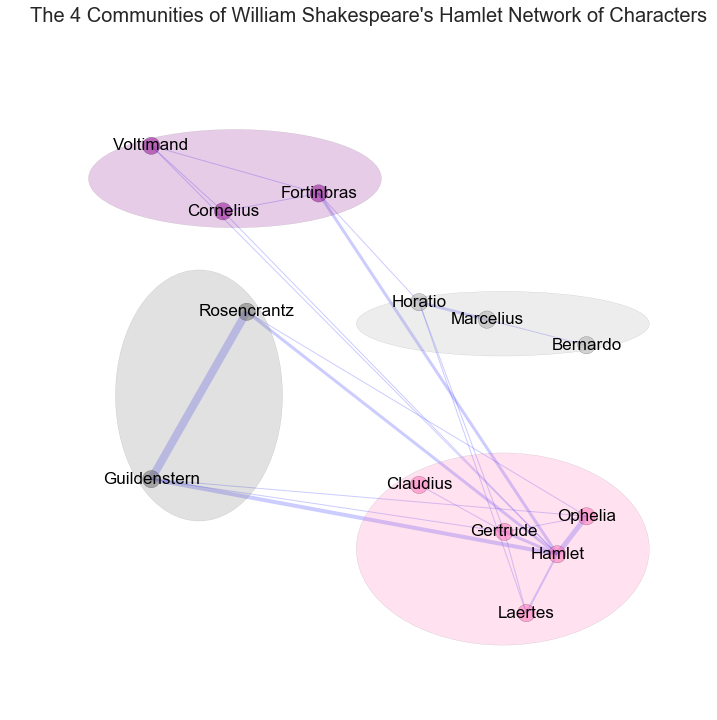

In [27]:
%autoreload 2

draw_comms=tool.draw_comms
modul_arity=tool.modul_arity
print_communities=tool.print_communities
part,nodper=print_communities(G,sstt)
ndfl=dflines[dflines['#_of_protagonists']>0  ]

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.2
vcc={}
sstta="The %s Communities of %s Network of Characters" %(max(part.values())+1,titlename)

draw_comms(G,G.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=17,valpha=0.5)

<a id='V'></a>
## V. Trajectories of Transitions among Sentential Co-Occurrences of Characters

### More about Transitions and Trajectories in Temporal Networks:

### http://www.slideshare.net/MosesBoudourides/trajectories1

In [28]:
%autoreload 2

trj= imp.load_source('trajectories', utilsdir+'trajectories_t.py')

### Transitions among Sentential Co-Occurrences of the Central Hero and Other Characters 

['Gertrude', 'Guildenstern', 'Ophelia', 'Laertes', 'Fortinbras', 'Cornelius']

Statistics of trajectories of first mode vertices

Cornelius [['Hamlet__13', 'Hamlet__14']]
1 trajectories analyzed.
['Hamlet']

Statistics of trajectories of second mode vertices

Hamlet [['Laertes__1', 'Laertes__16']]
1 trajectories analyzed.


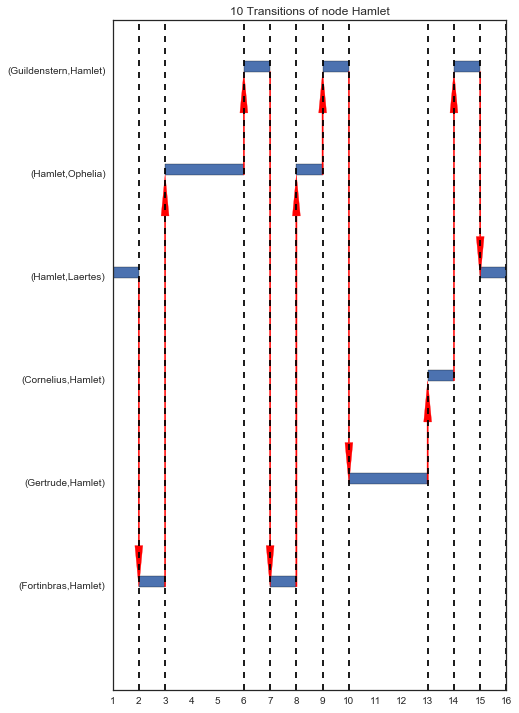

In [29]:
def search_in_list(x):
    l=x['protagonists']
    return central_hero in l
ndfl=dflines[dflines['#_of_protagonists']>1  ]
dialogs=ndfl[ndfl.apply(search_in_list,axis=1) ==True]
protagonists=dialogs.protagonists.tolist()
start=range(1,len(protagonists)+1)
end=range(2,len(protagonists)+2)
polarities=dialogs.polarity.tolist()
subj=dialogs.subjectivity.tolist()
qq=0
figi=None
search_name=central_hero

G,ndls,pold,subjd=trj.creatTestGraph_pandas_bips(start,end,protagonists,search_name,polarities,subj)
trajpdfs=trj.main_work_search_name(G,ndls,qq,figi,search_name,verb=False,plot_first_mode=False)

### Statistics of the Trajectory of Transitions among Sentential Co-Occurrences of the Central Hero and Other Characters 

In [30]:
trajpdfs[nn3]  #["['Hamlet']"]

,Vertices,fOriginator,fTransmitter,fTerminator,fBlackHole,fInvolvement,pOriginator,pTransmitter,pTerminator,pBlackHole,lOriginator,lTransmitter,lTerminator,lBlackHole,lInvolvement,Position,RelPosition,Betweenness
0,Gertrude,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,8.0,70.0,21.0
1,Guildenstern,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,7.0,60.0,63.0
2,Ophelia,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,4.5,35.0,32.0
3,Laertes,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,11.0,0.0,11.0,7.0,11.0,6.0,50.0,0.0
4,Fortinbras,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,3.5,25.0,18.0
5,Cornelius,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,11.0,0.0,0.0,11.0,9.0,80.0,16.0


### The Trajectory of Transitions among Sentential Co-Occurrences of the Central Hero and Other Characters:

#### Nodes are Co-Occurrences of the Central Hero with Other Characters 

#### The Color of Nodes Corresponds to Sentential Sentiment Polarities Varying from Color Red (-1) to Color Green (1)

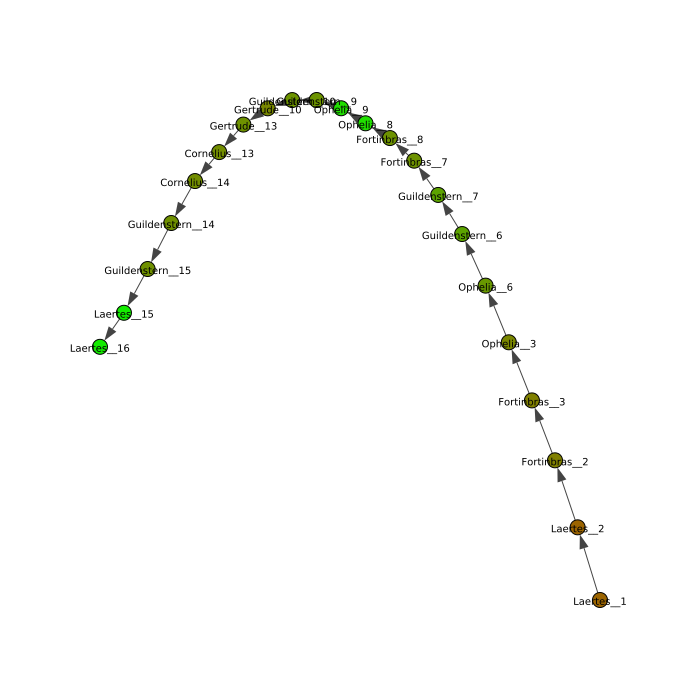

In [31]:
%autoreload 2
import igraph as ig

igraph_draw_traj=tool.igraph_draw_traj
filname=filename1 #'S_out_graphs/%s_graph.graphml' %search_name
g,visual_style,layout=igraph_draw_traj(filname,pold)

ig.plot(g,  **visual_style)

#### The Color of Nodes Corresponds to Sentential Sentiment Subjectivities Varying from Color Red (0) to Color Green (1)

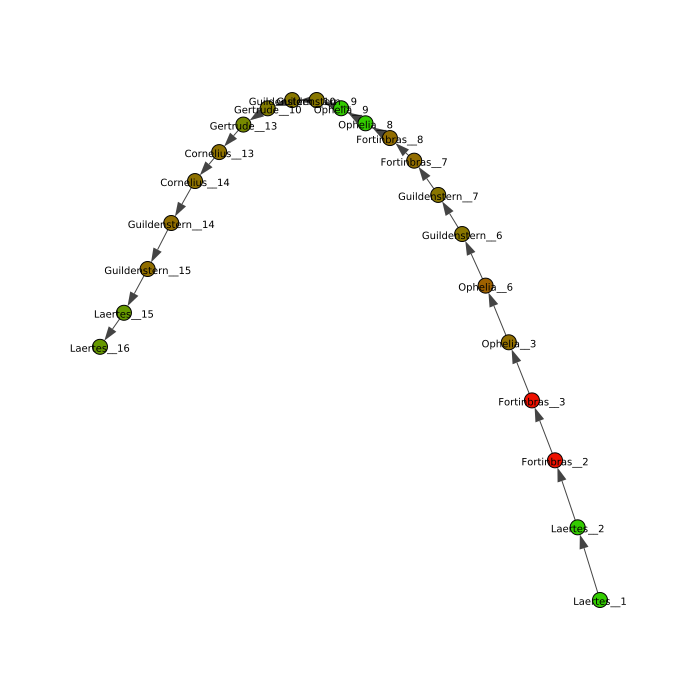

In [32]:
g,visual_style,layout=igraph_draw_traj(filname,subjd,polar=False,layout=layout)

ig.plot(g,  **visual_style)